In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler


class StandardScalerDf:
    
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, df):
        self.scaler.fit(df)
        
    def transform(self, df):
        df_ = self.scaler.transform(df)
        df_ = pd.DataFrame(df_, index=df.index, columns=df.columns)
        return df_


class LogitScalerStandardScaler:
    
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, df):
        df_ = np.log(df/(100 - df))
        self.scaler.fit(df_)
    
    def transform(self, df):
        df_ = np.log(df/(100 - df))
        df__ = self.scaler.transform(df_)
        df__ = pd.DataFrame(df__, index=df.index, columns=df.columns)
        return df__
    
    def inverse_transform(self, df__):
        df_ = self.scaler.inverse_transform(df__)
        df_ = pd.DataFrame(df_, index=df__.index, columns=df__.columns)
        df = 100 * np.exp(df_)/(1 + np.exp(df_))
        return df


class ZeroLogitRidgeCV:
    
    def __init__(self, X_train, X_test, y_train, y_test, groups):
        self.X_train = X_train
        self.X_test = X_test
        
        self.y_train = y_train
        self.y_test = y_test
        
        self.groups = groups
        
        self.X_pp = StandardScalerDf()
        self.X_pp.fit(self.X_train)
        self.X_train_ = self.X_pp.transform(self.X_train)
        self.X_test_ = self.X_pp.transform(self.X_test)
        
        self.y_pp = LogitScalerStandardScaler()
        self.y_pp.fit(self.y_train)
        self.y_train_ = self.y_pp.transform(self.y_train)
        self.y_test_ = self.y_pp.transform(self.y_test)
        
        self.model_ = None
        
        self.y_pred_train_ = None
        self.y_pred_test_ = None
        
        self.y_pred_train = None
        self.y_pred_test = None
        
    def fit(self):
        alpha = 100.0
        
        for i in range(1, -3, -1):
            model = Ridge()
            params = {
                "alpha":[alpha + j*10**(i) for j in range(-9, 10)]
            }
            gscv = GridSearchCV(
                model,
                params,
                cv=LeaveOneGroupOut(),
                scoring="neg_mean_squared_error",
                n_jobs=1,
                refit=True
            )
            gscv.fit(self.X_train_, self.y_train_, groups=self.groups)
            alpha = gscv.best_params_["alpha"]
            
        self.model_ = gscv.best_estimator_
    
    def predict(self):
        y_pred_train_ = self.model_.predict(self.X_train_)
        self.y_pred_train_ = pd.DataFrame(y_pred_train_, index=self.y_train_.index, columns=self.y_train_.columns)
        y_pred_test_ = self.model_.predict(self.X_test_)
        self.y_pred_test_ = pd.DataFrame(y_pred_test_, index=self.y_test_.index, columns=self.y_test_.columns)
        self.y_pred_train = self.y_pp.inverse_transform(self.y_pred_train_)
        self.y_pred_test = self.y_pp.inverse_transform(self.y_pred_test_)


In [2]:
from collections import defaultdict


X_path = "./X.csv"
X = pd.read_csv(X_path, index_col=["backbone", "pyridone"])
X = X.sub(X["0"], axis=0)
X = X.drop("0", axis=1)
display(X)

y_path = "./y.csv"
y = pd.read_csv(y_path, index_col=["backbone", "pyridone"])
display(y)

logo = LeaveOneGroupOut()
groups_outer = X.index.get_level_values("pyridone")
models = defaultdict(dict)

for i, (index_train, index_test) in enumerate(logo.split(X, y, groups_outer)):
    print(f"--- split={i} ---")
    columns = X.columns
    
    for n_features in range(len(X.columns), 4, -1):  # for n_features in range(len(X.columns), 4, -1)
        print(f"--- n_features={n_features} ---")
        X_train = X.iloc[index_train][columns]
        X_test = X.iloc[index_test][columns]
        y_train = y.iloc[index_train]
        y_test = y.iloc[index_test]
        groups_inner = X_train.index.get_level_values("pyridone")
        
        model = ZeroLogitRidgeCV(X_train, X_test, y_train, y_test, groups_inner)
        model.fit()
        print(model.model_.get_params()["alpha"])
        model.predict()
        models[X_test.index.get_level_values("pyridone")[0]][n_features] = model
        
        coef_df = pd.DataFrame(model.model_.coef_, index=["coef"], columns=columns)
        columns_min = coef_df.abs().idxmin(axis=1)
        columns = columns.drop(columns_min)


2         3         4         6         7         9  \
backbone pyridone                                                               
0        0        -0.008695 -0.057056 -0.008886 -0.026198 -0.041120  0.032579   
         1        -0.008695 -0.052599 -0.008886 -0.021780 -0.036864  0.032579   
         2        -0.008695 -0.054448 -0.008886 -0.023546 -0.038881  0.032579   
         3        -0.008695 -0.052436 -0.008886 -0.022054 -0.037311  0.032579   
         4        -0.008695 -0.053723 -0.008886 -0.025236 -0.039595  0.032579   
...                     ...       ...       ...       ...       ...       ...   
20       8        -0.008767 -0.046001 -0.008959 -0.024819 -0.038401  0.032447   
         9        -0.008767 -0.057810 -0.008959 -0.029390 -0.042452  0.032447   
         10       -0.008767 -0.046827 -0.008959 -0.026338 -0.039197  0.032447   
         11       -0.008767 -0.047412 -0.008959 -0.027697 -0.039272  0.032447   
         12       -0.008767 -0.056018 -0.008959 -0.026983 -0.040581  0.032447   

                         12        14        16        18  ...       507  \
backbone pyridone                                          ...             
0        0        -0.050338 -0.056655 -0.064589 -0.059825  ... -0.094124   
         1        -0.050736 -0.053830 -0.064255 -0.062201  ... -0.091687   
         2        -0.052990 -0.055201 -0.064532 -0.060393  ... -0.093373   
         3        -0.054012 -0.054275 -0.065711 -0.061291  ... -0.093179   
         4        -0.053024 -0.055508 -0.065862 -0.060430  ... -0.094225   
...                     ...       ...       ...       ...  ...       ...   
20       8        -0.047765 -0.056455 -0.062096 -0.060130  ... -0.091707   
         9        -0.053905 -0.055819 -0.067570 -0.058327  ... -0.094560   
         10       -0.049379 -0.056267 -0.064423 -0.059175  ... -0.091984   
         11       -0.053060 -0.056908 -0.067281 -0.056894  ... -0.092795   
         12       -0.051470 -0.054585 -0.066968 -0.060803  ... -0.092563   

                        519       538       540       543       575       597  \
backbone pyridone                                                               
0        0        -0.099624 -0.089446 -0.090086 -0.084177 -0.093292 -0.091567   
         1        -0.096809 -0.087070 -0.088095 -0.082335 -0.090797 -0.089023   
         2        -0.099589 -0.087857 -0.089579 -0.082563 -0.092372 -0.089866   
         3        -0.097998 -0.087177 -0.089471 -0.084803 -0.094709 -0.088976   
         4        -0.099139 -0.088837 -0.089840 -0.083402 -0.092848 -0.090779   
...                     ...       ...       ...       ...       ...       ...   
20       8        -0.093021 -0.084357 -0.088355 -0.081076 -0.090303 -0.081064   
         9        -0.102201 -0.088485 -0.091040 -0.083632 -0.092650 -0.085170   
         10       -0.094866 -0.084769 -0.089273 -0.082601 -0.090553 -0.081496   
         11       -0.095046 -0.083823 -0.090071 -0.081768 -0.091257 -0.081348   
         12       -0.100542 -0.087970 -0.088658 -0.082708 -0.090361 -0.084223   

                        602       605       642  
backbone pyridone                                
0        0        -0.079205 -0.087926 -0.089446  
         1        -0.075984 -0.085548 -0.087070  
         2        -0.078479 -0.086393 -0.087857  
         3        -0.078163 -0.085580 -0.087177  
         4        -0.078987 -0.087082 -0.088837  
...                     ...       ...       ...  
20       8        -0.073291 -0.083268 -0.083104  
         9        -0.079348 -0.087811 -0.088484  
         10       -0.074080 -0.083599 -0.083851  
         11       -0.074368 -0.083447 -0.083823  
         12       -0.076616 -0.086800 -0.087970  

[104 rows x 51 columns]

beta_av
backbone pyridone           
0        0         51.388357
         1         63.841924
         2         59.085161
         3         53.059721
         4         53.917807
...                      ...
20       8         19.228094
         9         24.595903
         10        21.060263
         11        19.203989
         12        23.601443

[104 rows x 1 columns]

--- split=0 ---
--- n_features=51 ---
22.310000000000002
--- n_features=50 ---
21.03
--- n_features=49 ---
19.29
--- n_features=48 ---
17.389999999999997
--- n_features=47 ---
17.26
--- n_features=46 ---
16.27
--- n_features=45 ---
15.94
--- n_features=44 ---
16.28
--- n_features=43 ---
16.27
--- n_features=42 ---
16.849999999999998
--- n_features=41 ---
10.91
--- n_features=40 ---
9.89
--- n_features=39 ---
3.96
--- n_features=38 ---
3.7
--- n_features=37 ---
3.7
--- n_features=36 ---
4.119999999999999
--- n_features=35 ---
4.49
--- n_features=34 ---
3.96
--- n_features=33 ---
3.3099999999999996
--- n_features=32 ---
3.18
--- n_features=31 ---
3.78
--- n_features=30 ---
3.52
--- n_features=29 ---
3.6700000000000004
--- n_features=28 ---
3.3499999999999996
--- n_features=27 ---
2.97
--- n_features=26 ---
2.52
--- n_features=25 ---
2.63
--- n_features=24 ---
2.48
--- n_features=23 ---
1.92
--- n_features=22 ---
1.94
--- n_features=21 ---
4.09
--- n_features=20 ---
4.04
--- n_features=19

0.6799999999999999
--- n_features=20 ---
0.65
--- n_features=19 ---
0.87
--- n_features=18 ---
0.89
--- n_features=17 ---
1.1400000000000001
--- n_features=16 ---
1.04
--- n_features=15 ---
1.3499999999999999
--- n_features=14 ---
1.61
--- n_features=13 ---
0.31999999999999995
--- n_features=12 ---
0.10999999999999997
--- n_features=11 ---
0.32999999999999996
--- n_features=10 ---
0.02999999999999997
--- n_features=9 ---
0.009999999999999981
--- n_features=8 ---
0.08999999999999998
--- n_features=7 ---
0.20999999999999996
--- n_features=6 ---
0.2799999999999999
--- n_features=5 ---
0.3499999999999999
--- split=6 ---
--- n_features=51 ---
20.45
--- n_features=50 ---
19.28
--- n_features=49 ---
7.3500000000000005
--- n_features=48 ---
7.66
--- n_features=47 ---
6.98
--- n_features=46 ---
5.17
--- n_features=45 ---
3.98
--- n_features=44 ---
3.84
--- n_features=43 ---
2.76
--- n_features=42 ---
2.66
--- n_features=41 ---
2.89
--- n_features=40 ---
3.38
--- n_features=39 ---
5.380000000000

15.52
--- n_features=40 ---
15.08
--- n_features=39 ---
14.39
--- n_features=38 ---
14.97
--- n_features=37 ---
12.32
--- n_features=36 ---
10.51
--- n_features=35 ---
9.260000000000002
--- n_features=34 ---
8.99
--- n_features=33 ---
8.04
--- n_features=32 ---
7.8
--- n_features=31 ---
6.9
--- n_features=30 ---
7.05
--- n_features=29 ---
6.19
--- n_features=28 ---
6.52
--- n_features=27 ---
6.09
--- n_features=26 ---
6.1
--- n_features=25 ---
5.569999999999999
--- n_features=24 ---
5.64
--- n_features=23 ---
5.41
--- n_features=22 ---
4.53
--- n_features=21 ---
5.99
--- n_features=20 ---
5.79
--- n_features=19 ---
5.81
--- n_features=18 ---
4.52
--- n_features=17 ---
2.34
--- n_features=16 ---
4.01
--- n_features=15 ---
3.74
--- n_features=14 ---
3.13
--- n_features=13 ---
2.7
--- n_features=12 ---
2.01
--- n_features=11 ---
0.8500000000000001
--- n_features=10 ---
1.95
--- n_features=9 ---
2.9
--- n_features=8 ---
2.25
--- n_features=7 ---
2.29
--- n_features=6 ---
1.91
--- n_feature

In [3]:
models_df = pd.DataFrame.from_dict(models).T
display(models_df)


,51,50,49,48,47,46,45,44,43,42,...,14,13,12,11,10,9,8,7,6,5
0,<__main__.ZeroLogitRidgeCV object at 0x15bf2a220>,<__main__.ZeroLogitRidgeCV object at 0x15bf507f0>,<__main__.ZeroLogitRidgeCV object at 0x15bf50580>,<__main__.ZeroLogitRidgeCV object at 0x15bf65700>,<__main__.ZeroLogitRidgeCV object at 0x15df936d0>,<__main__.ZeroLogitRidgeCV object at 0x15dfad4f0>,<__main__.ZeroLogitRidgeCV object at 0x15dfb0040>,<__main__.ZeroLogitRidgeCV object at 0x15dfc0850>,<__main__.ZeroLogitRidgeCV object at 0x15dfc8e20>,<__main__.ZeroLogitRidgeCV object at 0x15dfadb20>,...,<__main__.ZeroLogitRidgeCV object at 0x15e0b39a0>,<__main__.ZeroLogitRidgeCV object at 0x15e0c4f40>,<__main__.ZeroLogitRidgeCV object at 0x15e06fdf0>,<__main__.ZeroLogitRidgeCV object at 0x15e095df0>,<__main__.ZeroLogitRidgeCV object at 0x15e0d0250>,<__main__.ZeroLogitRidgeCV object at 0x15e0df190>,<__main__.ZeroLogitRidgeCV object at 0x15e0dec10>,<__main__.ZeroLogitRidgeCV object at 0x15e0f5790>,<__main__.ZeroLogitRidgeCV object at 0x15e100d30>,<__main__.ZeroLogitRidgeCV object at 0x15e108550>
1,<__main__.ZeroLogitRidgeCV object at 0x15e100940>,<__main__.ZeroLogitRidgeCV object at 0x15e112d90>,<__main__.ZeroLogitRidgeCV object at 0x15e1185e0>,<__main__.ZeroLogitRidgeCV object at 0x15e129490>,<__main__.ZeroLogitRidgeCV object at 0x15e0e79a0>,<__main__.ZeroLogitRidgeCV object at 0x15e131310>,<__main__.ZeroLogitRidgeCV object at 0x15e13f790>,<__main__.ZeroLogitRidgeCV object at 0x15e13f2b0>,<__main__.ZeroLogitRidgeCV object at 0x15e14bfa0>,<__main__.ZeroLogitRidgeCV object at 0x15e14d970>,...,<__main__.ZeroLogitRidgeCV object at 0x15e04dbb0>,<__main__.ZeroLogitRidgeCV object at 0x15e223e50>,<__main__.ZeroLogitRidgeCV object at 0x15e226460>,<__main__.ZeroLogitRidgeCV object at 0x15e22dbb0>,<__main__.ZeroLogitRidgeCV object at 0x15e237ee0>,<__main__.ZeroLogitRidgeCV object at 0x15e23a940>,<__main__.ZeroLogitRidgeCV object at 0x15e237b20>,<__main__.ZeroLogitRidgeCV object at 0x15e259d90>,<__main__.ZeroLogitRidgeCV object at 0x15e22de80>,<__main__.ZeroLogitRidgeCV object at 0x15e267cd0>
2,<__main__.ZeroLogitRidgeCV object at 0x15e264040>,<__main__.ZeroLogitRidgeCV object at 0x15e267040>,<__main__.ZeroLogitRidgeCV object at 0x15e27cc40>,<__main__.ZeroLogitRidgeCV object at 0x15e284f40>,<__main__.ZeroLogitRidgeCV object at 0x15e28d910>,<__main__.ZeroLogitRidgeCV object at 0x15e290460>,<__main__.ZeroLogitRidgeCV object at 0x15e2a2c40>,<__main__.ZeroLogitRidgeCV object at 0x15e29b430>,<__main__.ZeroLogitRidgeCV object at 0x15e2b16a0>,<__main__.ZeroLogitRidgeCV object at 0x15e2bcd90>,...,<__main__.ZeroLogitRidgeCV object at 0x15e3a57f0>,<__main__.ZeroLogitRidgeCV object at 0x15e38e640>,<__main__.ZeroLogitRidgeCV object at 0x15e3b4df0>,<__main__.ZeroLogitRidgeCV object at 0x15e3baaf0>,<__main__.ZeroLogitRidgeCV object at 0x15e3bde80>,<__main__.ZeroLogitRidgeCV object at 0x15e3cc400>,<__main__.ZeroLogitRidgeCV object at 0x15e3d2ac0>,<__main__.ZeroLogitRidgeCV object at 0x15e3d0280>,<__main__.ZeroLogitRidgeCV object at 0x15e2ffe20>,<__main__.ZeroLogitRidgeCV object at 0x15e247fd0>
3,<__main__.ZeroLogitRidgeCV object at 0x15e20a160>,<__main__.ZeroLogitRidgeCV object at 0x15dfd22b0>,<__main__.ZeroLogitRidgeCV object at 0x15e3e25b0>,<__main__.ZeroLogitRidgeCV object at 0x15e3d2910>,<__main__.ZeroLogitRidgeCV object at 0x15e2ac130>,<__main__.ZeroLogitRidgeCV object at 0x15e3d73a0>,<__main__.ZeroLogitRidgeCV object at 0x15e3e8f10>,<__main__.ZeroLogitRidgeCV object at 0x15e404e20>,<__main__.ZeroLogitRidgeCV object at 0x15e408a00>,<__main__.ZeroLogitRidgeCV object at 0x15e41baf0>,...,<__main__.ZeroLogitRidgeCV object at 0x15e4b8070>,<__main__.ZeroLogitRidgeCV object at 0x15e50a5b0>,<__main__.ZeroLogitRidgeCV object at 0x15e501fd0>,<__main__.ZeroLogitRidgeCV object at 0x15e515940>,<__main__.ZeroLogitRidgeCV object at 0x15e5012b0>,<__main__.ZeroLogitRidgeCV object at 0x15e525bb0>,<__main__.ZeroLogitRidgeCV object at 0x15e531f40>,<__main__.ZeroLogitRidgeCV object at 0x15e52d790>,<__main__.ZeroLo

In [4]:
import pickle


models_path = "./Ridge_RFE_zero_models.pickle"

with open(models_path, "wb") as f:
    pickle.dump(models_df, f)
    

In [5]:
import pickle

models_path = "./Ridge_RFE_zero_models.pickle"

with open(models_path, "rb") as f:
    models_df = pickle.load(f)
    

In [6]:
from sklearn.metrics import mean_squared_error


rmse_y_train_concat = {}
rmse_y_test_concat = {}

for column in models_df.columns:
    y_train_concat = pd.concat([model.y_train for model in models_df[column]])
    y_test_concat = pd.concat([model.y_test for model in models_df[column]])
    y_pred_train_concat = pd.concat([model.y_pred_train for model in models_df[column]])
    y_pred_test_concat = pd.concat([model.y_pred_test for model in models_df[column]])
    rmse_y_train_concat[column] = mean_squared_error(y_train_concat, y_pred_train_concat, squared=False)
    rmse_y_test_concat[column] = mean_squared_error(y_test_concat, y_pred_test_concat, squared=False)

rmse_concat_df = pd.DataFrame({"rmse_train": rmse_y_train_concat, "rmse_test": rmse_y_test_concat}).T
display(rmse_concat_df)


,51,50,49,48,47,46,45,44,43,42,...,14,13,12,11,10,9,8,7,6,5
rmse_train,4.646271,4.612375,4.484954,4.466735,4.425488,4.409634,4.39178,4.400595,4.365491,4.351972,...,4.014138,4.046327,4.044202,4.028872,4.106214,4.299564,4.503741,4.752061,4.948247,5.430574
rmse_test,7.174818,7.181588,7.154400,7.145989,7.160939,7.143872,7.14221,7.128265,7.118101,7.095213,...,6.173810,6.316441,6.530511,7.022127,7.172801,7.269800,7.354834,7.986625,8.077805,8.385205


In [7]:
import pickle


rmse_path = "./Ridge_RFE_zero_RMSE.pickle"

with open(rmse_path, "wb") as f:
    pickle.dump(rmse_concat_df, f)
    

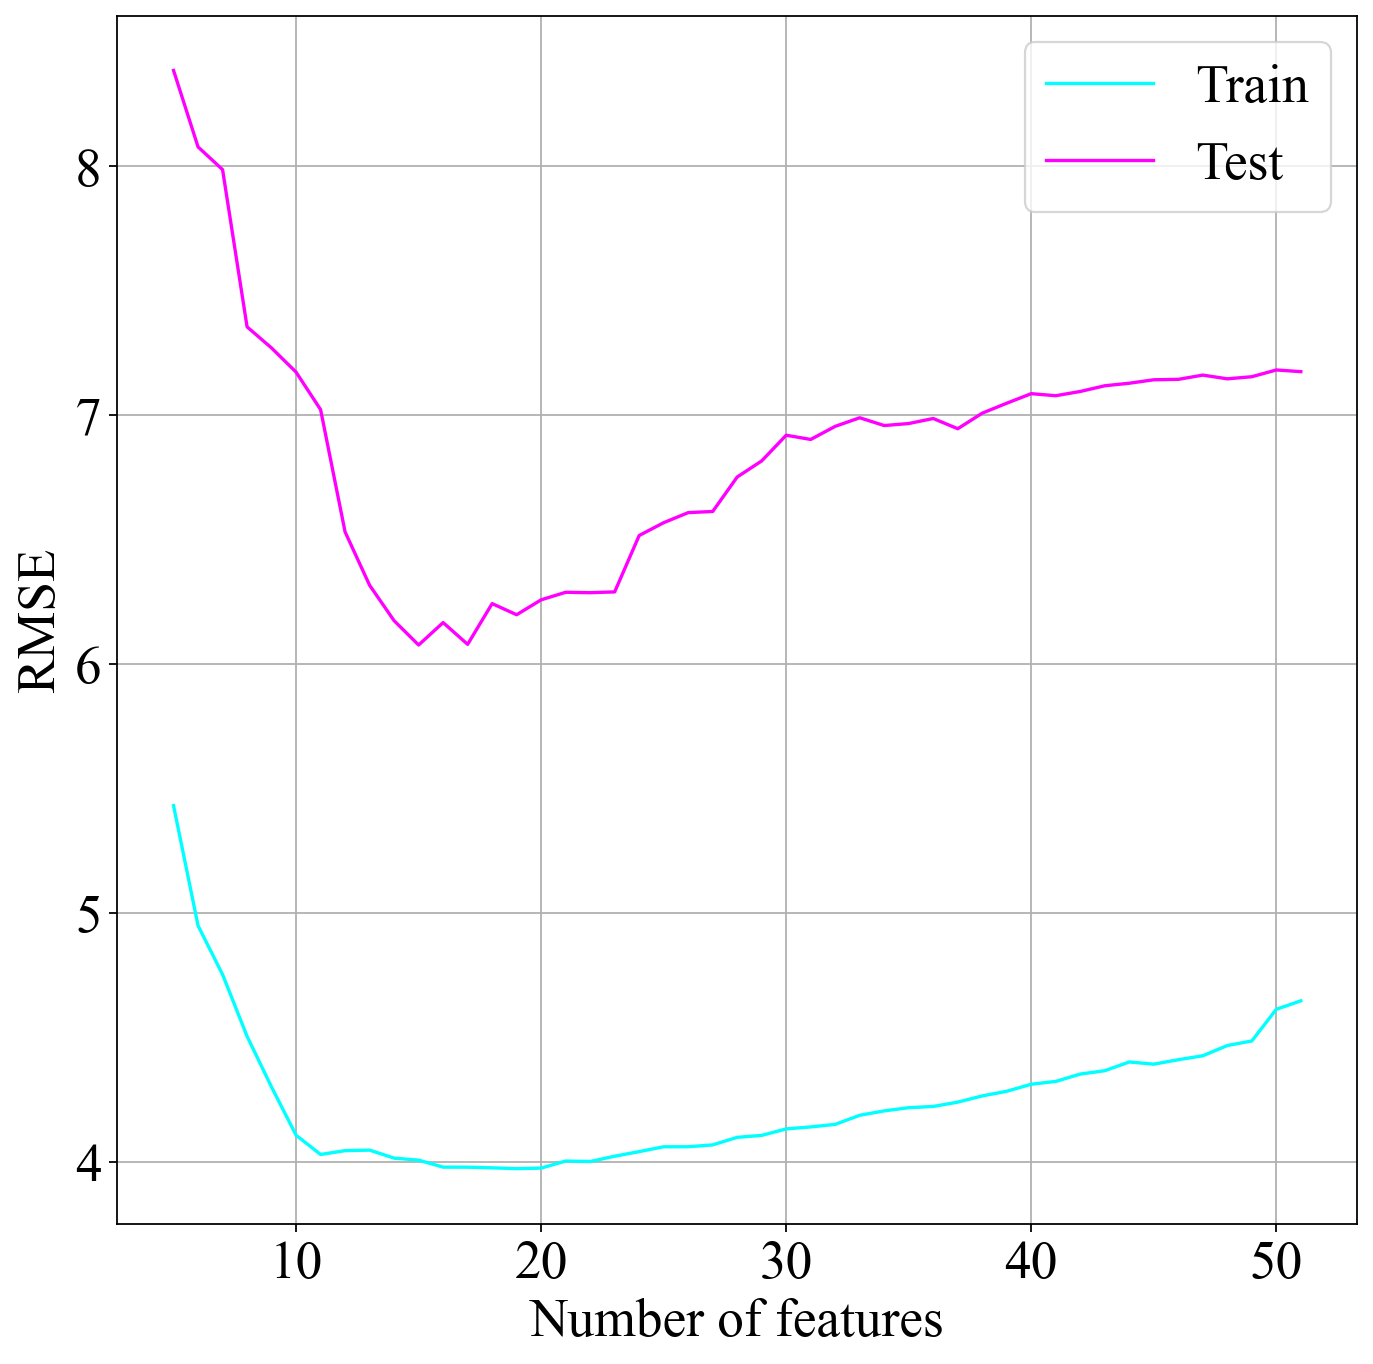

In [8]:
import matplotlib.pyplot as plt


plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Number of features")
ax.set_ylabel("RMSE")
ax.plot(rmse_concat_df.columns, rmse_concat_df.loc["rmse_train"], color="cyan", label="Train")
ax.plot(rmse_concat_df.columns, rmse_concat_df.loc["rmse_test"], color="magenta", label="Test")
ax.grid()
ax.legend()
plt.savefig("./Ridge_RFE_zero_RMSE.png")
plt.show()


In [9]:
n_features_min = rmse_concat_df.loc["rmse_train"].idxmin()
print(n_features_min)

19


In [10]:
print(rmse_concat_df.at["rmse_test", n_features_min])

6.197880685742037


In [11]:
y_train_concat = pd.concat([model.y_train for model in models_df[n_features_min]])
y_pred_train_concat = pd.concat([model.y_pred_train for model in models_df[n_features_min]])
y_test_concat = pd.concat([model.y_test for model in models_df[n_features_min]])
y_pred_test_concat = pd.concat([model.y_pred_test for model in models_df[n_features_min]])


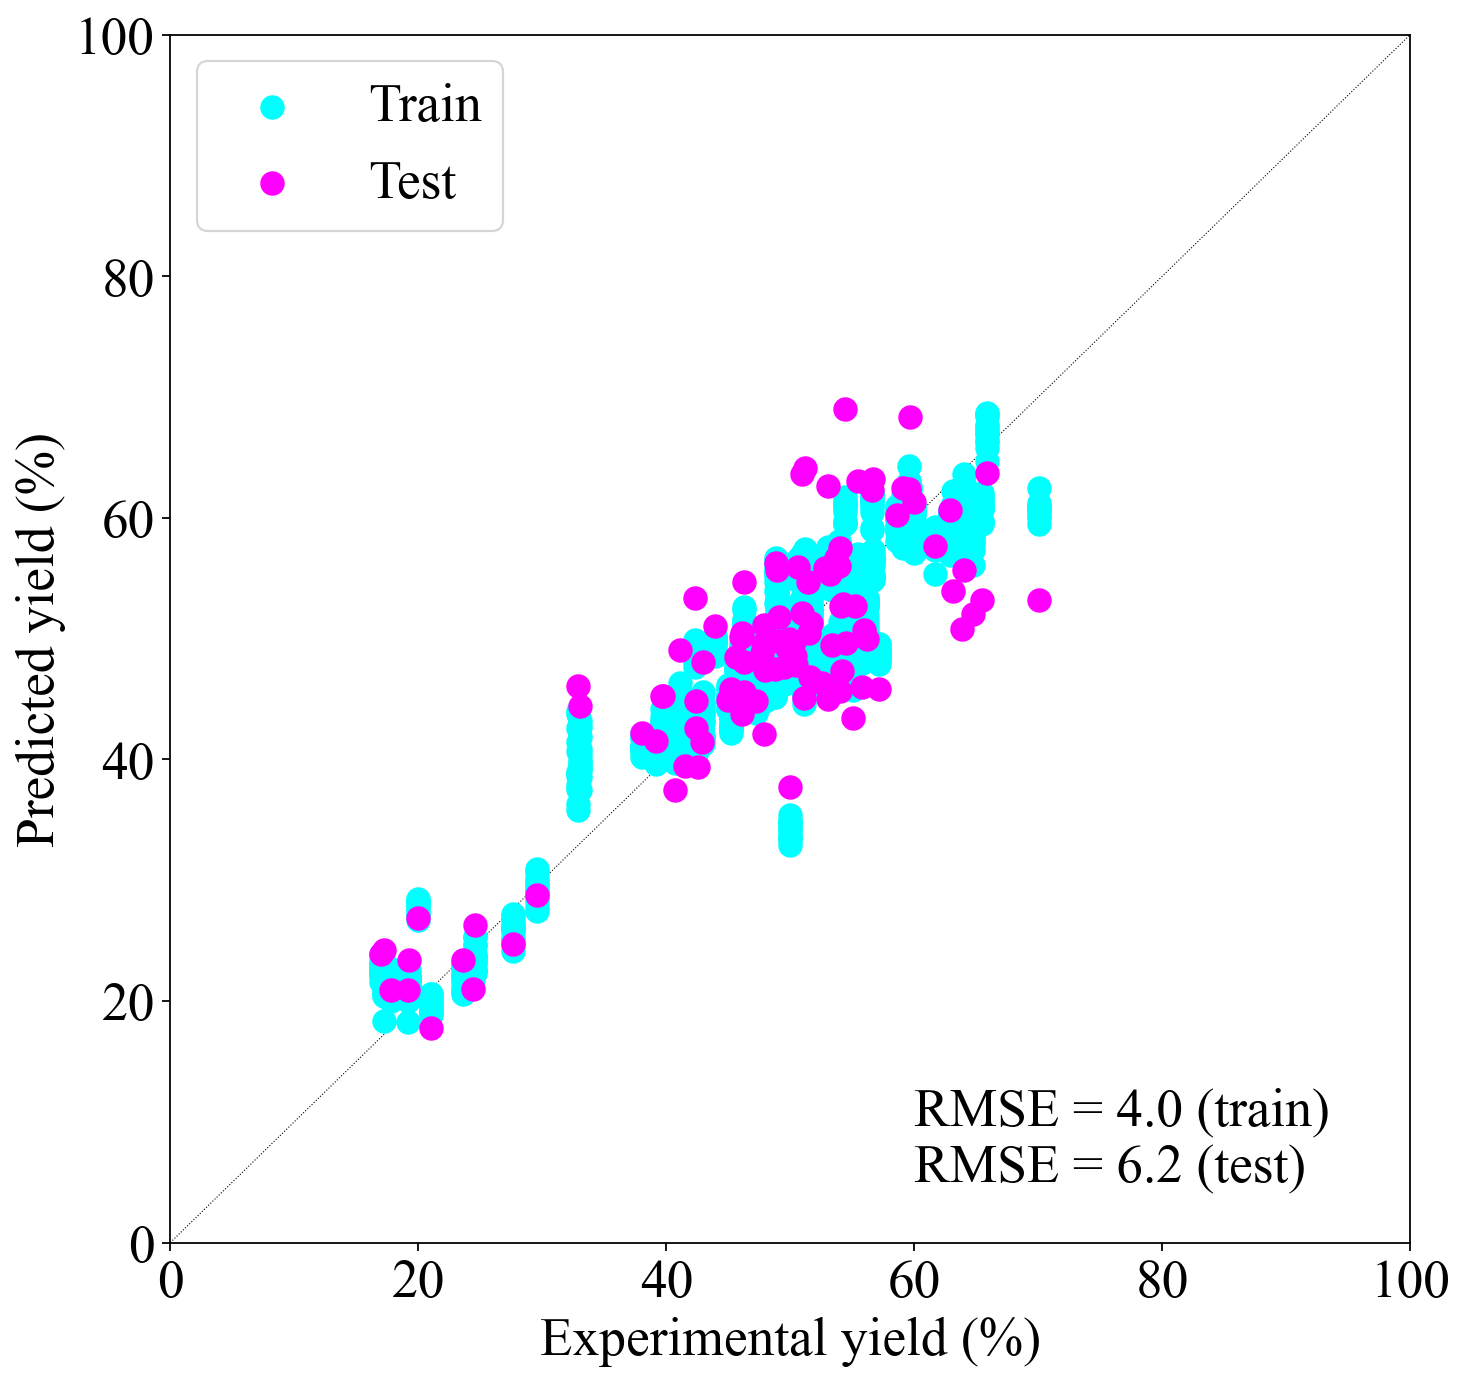

In [12]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Experimental yield (%)")
ax.set_ylabel("Predicted yield (%)")
ax.plot(
    [0, 100], [0, 100],
    color="black", linewidth=0.5, linestyle="dotted", zorder=0
)
ax.scatter(
    y_train_concat, y_pred_train_concat,
    color="cyan", s=100, label="Train", zorder=1
)
ax.scatter(
    y_test_concat, y_pred_test_concat,
    color="magenta", s=100, label="Test", zorder=2
)
ax.text(
    60, 5,
    f"RMSE = {mean_squared_error(y_train_concat, y_pred_train_concat, squared=False):1.1f} (train)\n"
    f"RMSE = {mean_squared_error(y_test_concat, y_pred_test_concat, squared=False):1.1f} (test)"
)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.legend()
plt.savefig("./Ridge_RFE_zero_scatter_all.png")
plt.show()


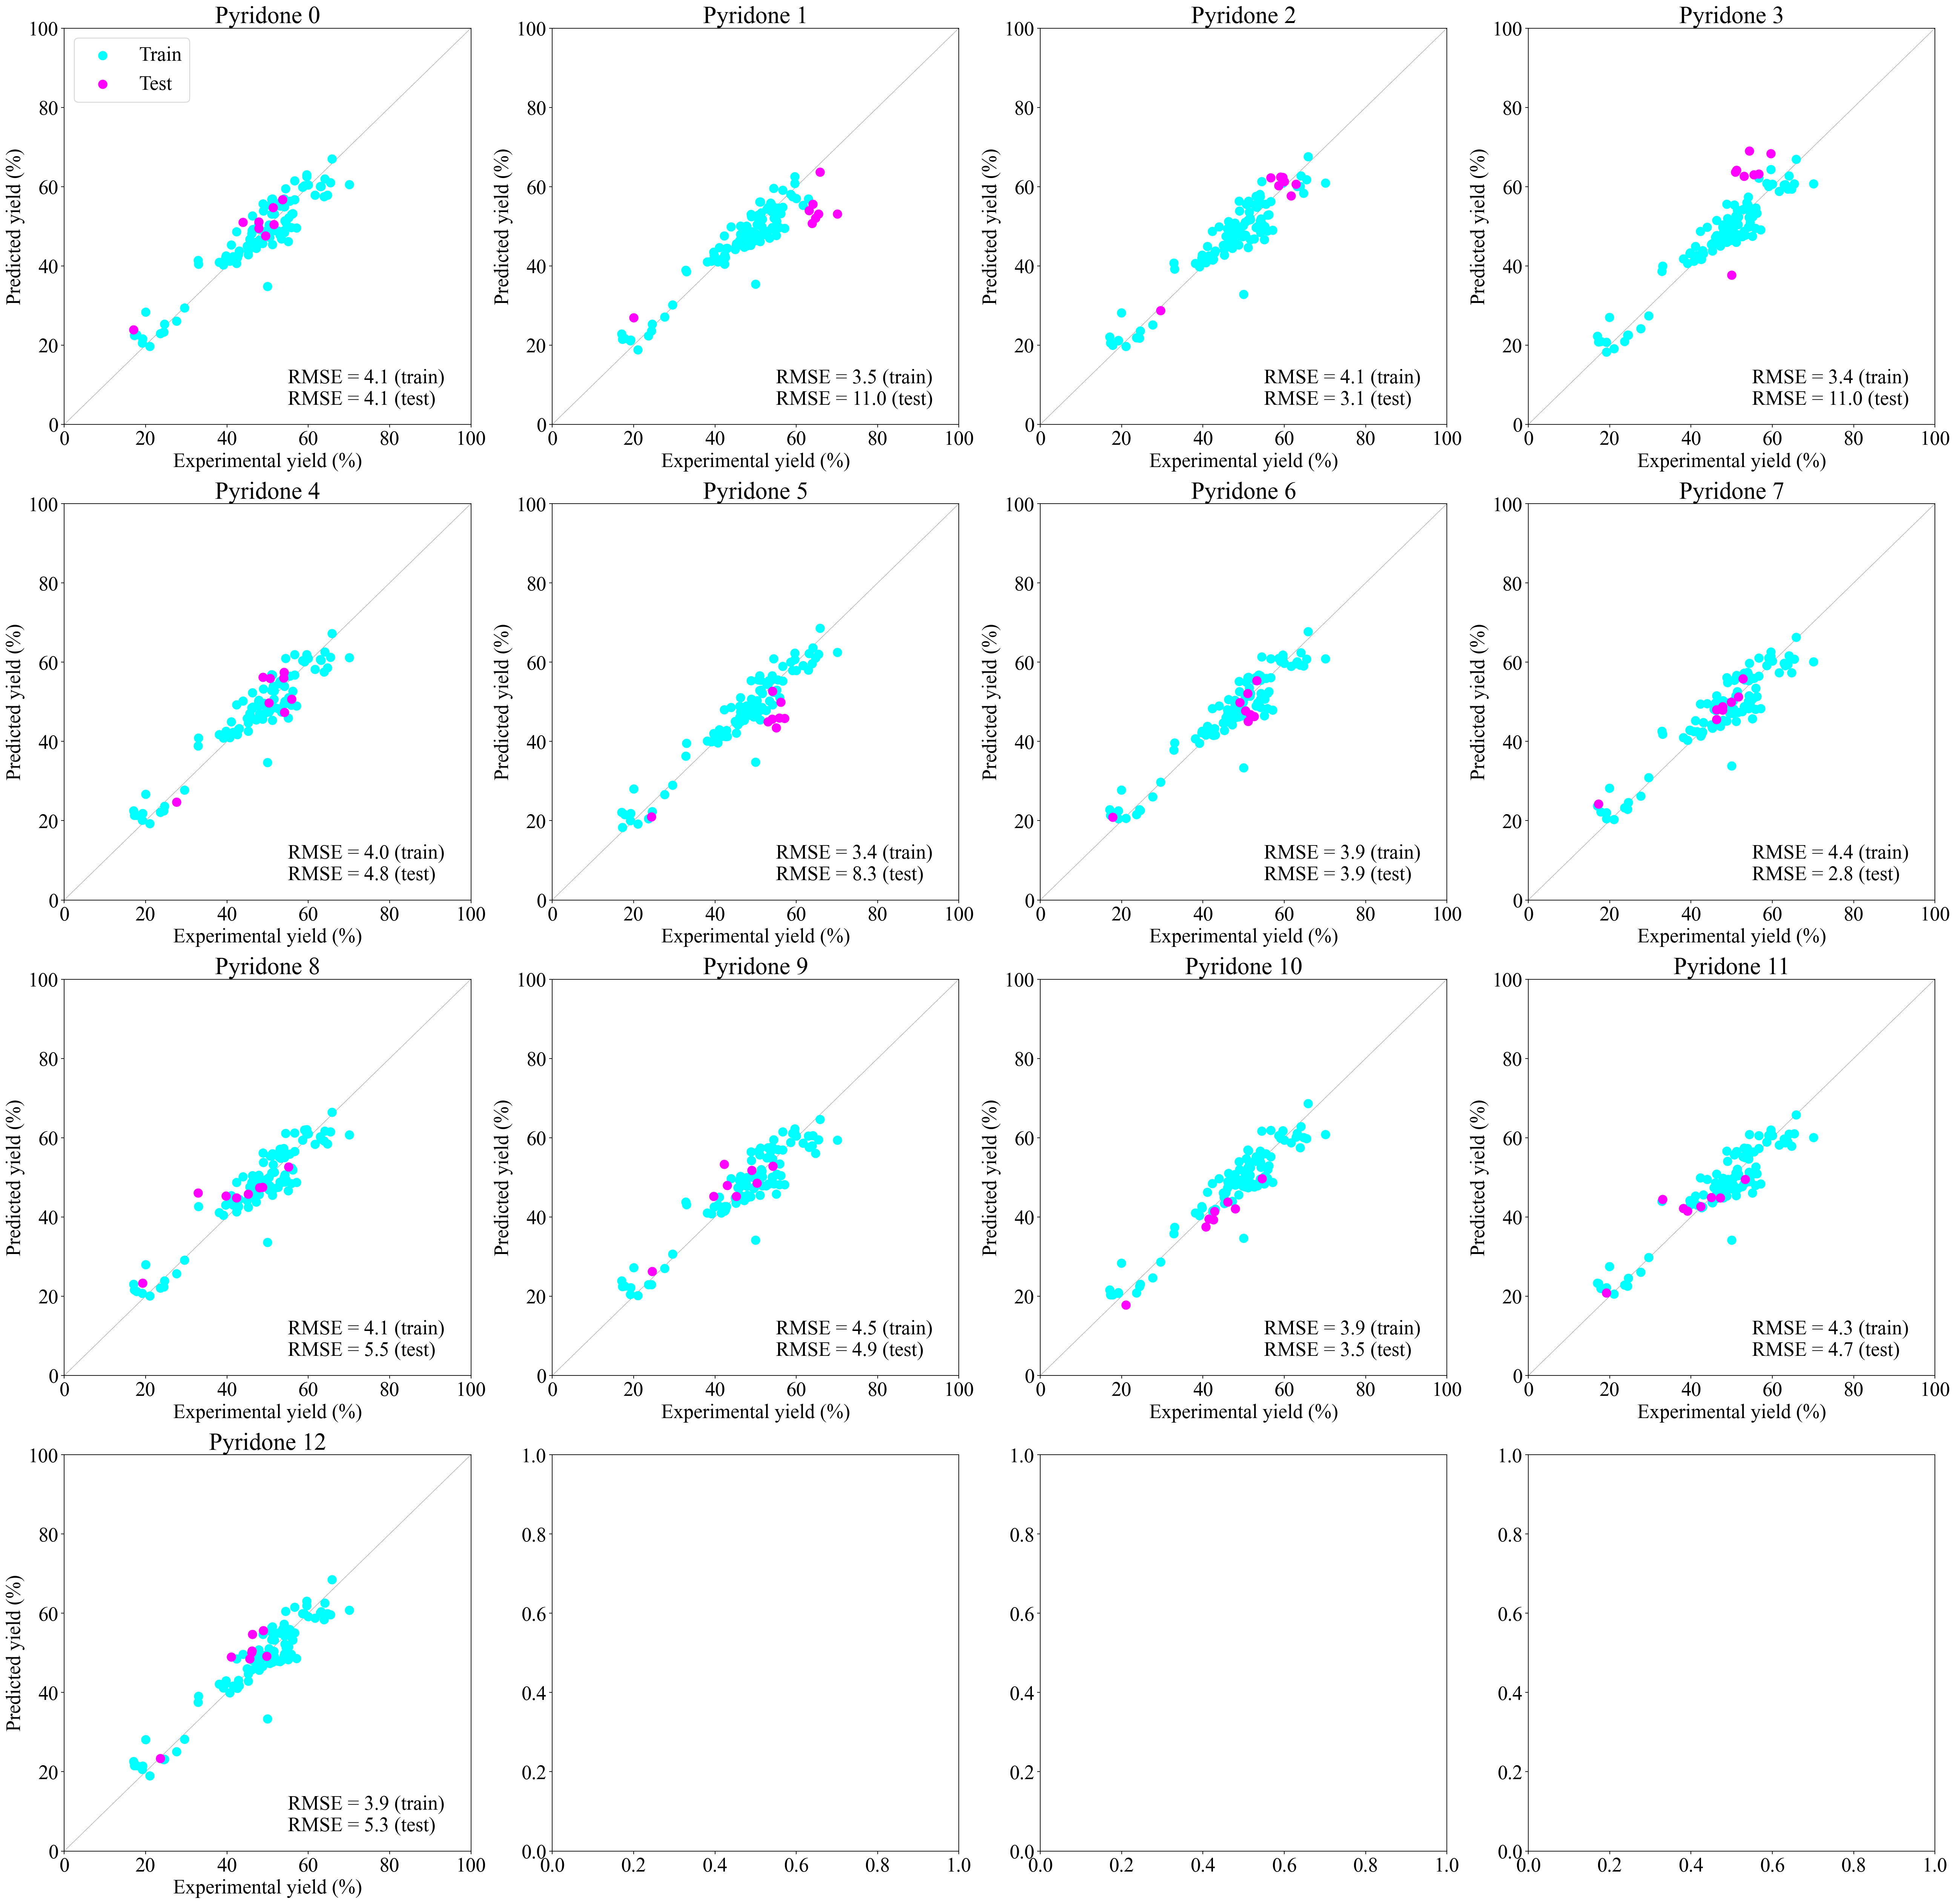

In [13]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, axes = plt.subplots(4, 4, figsize=(40, 40))

for i, (num, model) in enumerate(models_df[n_features_min].items()):
    div, mod = divmod(i, 4)
    axes[div, mod].set_title(f"Pyridone {num}")
    axes[div, mod].set_xlabel("Experimental yield (%)")
    axes[div, mod].set_ylabel("Predicted yield (%)")
    axes[div, mod].plot(
        [0, 100], [0, 100],
        color="black", linewidth=0.5, linestyle="dotted", zorder=0
    )
    axes[div, mod].scatter(
        model.y_train, model.y_pred_train,
        color="cyan", s=100, label="Train", zorder=1
    )
    axes[div, mod].scatter(
        model.y_test, model.y_pred_test,
        color="magenta", s=100, label="Test", zorder=2
    )
    axes[div, mod].text(
        55, 5,
        f"RMSE = {mean_squared_error(model.y_train, model.y_pred_train, squared=False):1.1f} (train)\n"
        f"RMSE = {mean_squared_error(model.y_test, model.y_pred_test, squared=False):1.1f} (test)"
    )
    axes[div, mod].set_xlim(0, 100)
    axes[div, mod].set_ylim(0, 100)
    if i == 0:
        axes[div, mod].legend()
    
plt.savefig("./Ridge_RFE_zero_scatter_each.png")
plt.show()


In [14]:
coef_dfs = []

for num, model in models_df[n_features_min].items():
    coef_df = pd.DataFrame(model.model_.coef_.reshape(1, -1), index=[num], columns=model.X_train.columns)
    coef_dfs.append(coef_df)
    
coef_dfs_concat = pd.concat(coef_dfs, axis=0, join="outer")
coef_dfs_concat = coef_dfs_concat.reindex(columns=sorted(coef_dfs_concat.columns, key=int))
coef_dfs_concat = coef_dfs_concat.fillna(0)
coef_dfs_concat.loc["mean"] = coef_dfs_concat.mean()
display(coef_dfs_concat)

,2,3,4,6,7,9,12,14,16,19,...,465,469,494,506,507,540,543,575,597,605
0,-0.171401,0.000000,0.000000,0.000000,0.287380,-0.230059,0.098309,0.000000,0.000000,0.000000,...,0.000000,-0.271669,0.165942,-0.310632,0.072454,0.000000,0.388169,0.000000,-0.127591,0.000000
1,0.000000,0.000000,0.000000,0.123767,0.203157,-0.225702,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.258736,0.248923,-0.317679,0.000000,0.000000,0.341862,-0.108114,0.000000,0.000000
2,-0.173689,0.000000,0.000000,-0.217517,0.433434,-0.080633,0.150008,0.089467,0.043022,0.000000,...,0.000000,-0.301295,0.260477,-0.338577,0.000000,0.000000,0.386605,0.000000,0.112520,0.000000
3,-0.135868,0.000000,0.000000,0.000000,0.342299,-0.307087,0.130729,0.000000,0.000000,0.000000,...,0.000000,-0.207404,0.180142,-0.207440,0.000000,0.000000,0.212704,0.000000,-0.152919,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.278203,-0.249463,0.099276,0.000000,0.000000,0.000000,...,0.000000,-0.255275,0.164409,-0.313825,0.111555,0.000000,0.406887,0.000000,-0.202848,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.576660,-0.222920,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.264876,0.000000,0.000000,0.225235,0.000000,0.412495,0.000000,-0.362648,-0.441928
6,0.000000,-0.103051,0.000000,0.000000,0.391329,-0.164299,0.134193,0.000000,0.000000,0.000000,...,0.000000,-0.236264,0.187989,-0.256925,0.000000,0.000000,0.355873,0.000000,-0.152364,0.000000
7,-0.107143,0.000000,0.000000,0.000000,0.255976,-0.199019,0.126118,0.107531,0.000000,0.000000,...,-0.156514,-0.168551,0.168702,-0.184030,0.000000,0.000000,0.312771,0.000000,-0.145331,0.000000
8,-0.130686,0.000000,-0.096192,-0.003742,0.315092,-0.131111,0.114939,0.000000,0.000000,0.000000,...,0.000000,-0.137004,0.162665,-0.302058,0.000000,0.000000,0.365683,0.000000,-0.019768,0.000000
9,-0.104447,0.000000,0.000000,0.000000,0.206925,-0.184389,0.000000,0.102437,0.000000,0.100945,...,0.000000,-0.140063,0.157045,-0.235747,0.000000,0.000000,0.250705,0.000000,-0.175053,0.000000


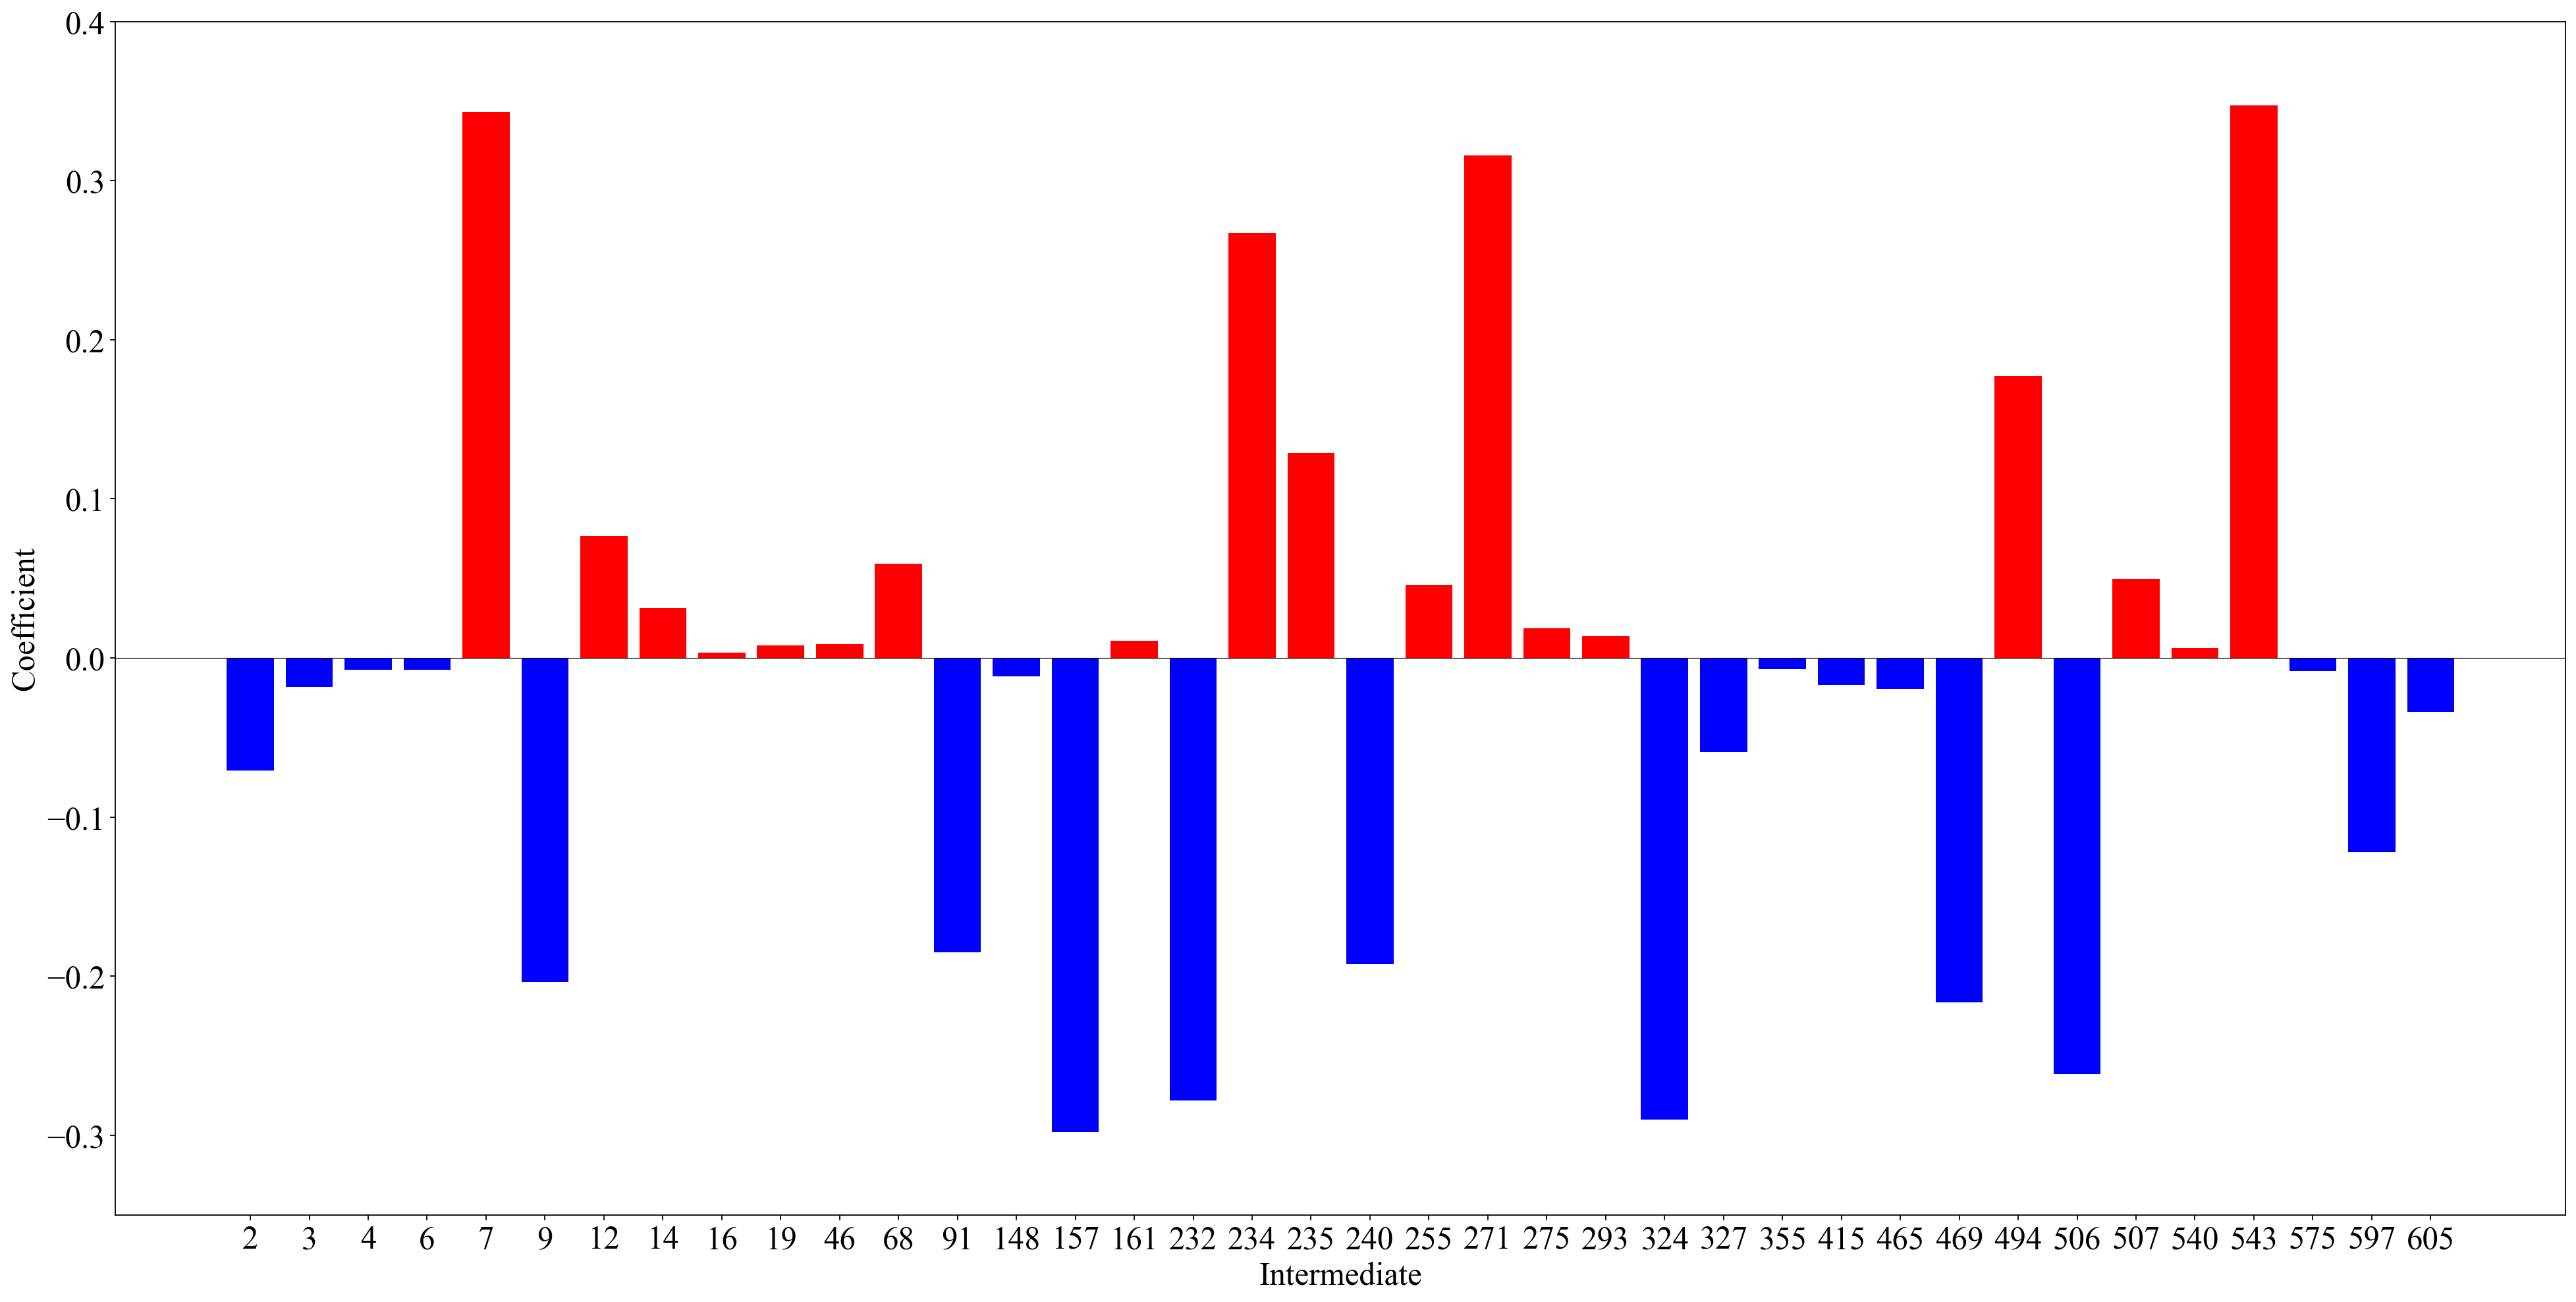

In [15]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
ax.set_xlabel("Intermediate")
ax.set_ylabel("Coefficient")
ax.bar(coef_dfs_concat.loc["mean"].index, coef_dfs_concat.loc["mean"]*(coef_dfs_concat.loc["mean"]>0), color="red")
ax.bar(coef_dfs_concat.loc["mean"].index, coef_dfs_concat.loc["mean"]*(coef_dfs_concat.loc["mean"]<0), color="blue")
ax.axhline(y=0.0, linewidth=0.5, color="black")
ax.set_ylim(-0.35, 0.4)
plt.savefig("./Ridge_RFE_zero_coefficient.png")
plt.show()


In [16]:
coef_dfs_concat.loc["mean"]

2     -0.070936
3     -0.018276
4     -0.007399
6     -0.007499
7      0.343268
9     -0.203820
12     0.076725
14     0.031289
16     0.003309
19     0.007765
46     0.008519
68     0.059035
91    -0.184946
148   -0.011615
157   -0.297951
161    0.010658
232   -0.278095
234    0.266890
235    0.128666
240   -0.192503
255    0.045793
271    0.315712
275    0.018679
293    0.013517
324   -0.290328
327   -0.059315
355   -0.006864
415   -0.016946
465   -0.019334
469   -0.216540
494    0.177150
506   -0.261477
507    0.049633
540    0.006234
543    0.347292
575   -0.008316
597   -0.122259
605   -0.033994
Name: mean, dtype: float64